In [36]:
import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [37]:
df = pd.read_csv("churn_data.csv")
df.head(5)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [38]:
df = df.drop(['CustomerId', 'RowNumber'], axis=1)
df.head(5)

,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [39]:
X = df.drop("Exited", axis=1)
y = df["Exited"]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [40]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

In [41]:
categorical_columns = ['Geography', 'Gender', 'Tenure', 'HasCrCard', 'IsActiveMember']
continuous_columns = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']

In [42]:
final_transformers = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    final_transformers.append((cat_col, cat_transformer))
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())])
    final_transformers.append((cont_col, cont_transformer))

In [43]:
feats = FeatureUnion(final_transformers)

feature_processing = Pipeline([('feats', feats)])

In [44]:
pipeline = Pipeline([
    ('features', feats),
    ('classifier', RandomForestClassifier(random_state=42))
])

In [45]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

In [46]:
preds = pipeline.predict_proba(X_test)[:, 1]
preds[:10]

array([0.37, 0.26, 0.17, 0.02, 0.02, 0.67, 0.04, 0.12, 0.15, 0.75])

In [47]:
def cal_metrics(y_test, preds):
    b=1
    precision, recall, thresholds = precision_recall_curve(y_test.values, preds)
    fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
    ix = np.argmax(fscore)
    roc_auc = roc_auc_score(y_test, preds)
    
    metrics = (roc_auc, fscore[ix], precision[ix], recall[ix])
    thresholds = thresholds[ix]
    
    return metrics, thresholds

In [48]:
metrics_forest, thresholds_forest = cal_metrics(y_test, preds)

metrics_forest

(0.8636990228128739, 0.6412825651302605, 0.65439672801636, 0.6286836935166994)

In [49]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1833  158]
 [ 195  314]]


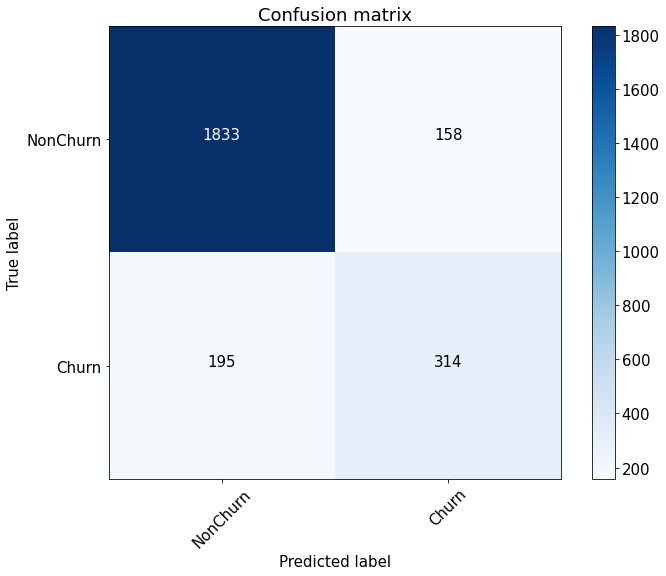

In [50]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds_forest)
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

# LGBM

In [51]:
pipeline = Pipeline([
    ('features',feats),
    ('classifier', LGBMClassifier(random_state = 42)),
])

In [52]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

In [53]:
preds = pipeline.predict_proba(X_test)[:, 1]
preds[:10]

array([0.43369048, 0.24735086, 0.1632904 , 0.04189257, 0.05688283,
       0.92200055, 0.03408225, 0.09064776, 0.10556057, 0.69556762])

In [54]:
metrics_lgbm, thresholds_lgbm = cal_metrics(y_test, preds)

metrics_lgbm

(0.8705757440900554,
 0.6534260178748758,
 0.6606425702811245,
 0.6463654223968566)

Confusion matrix, without normalization
[[1822  169]
 [ 181  328]]


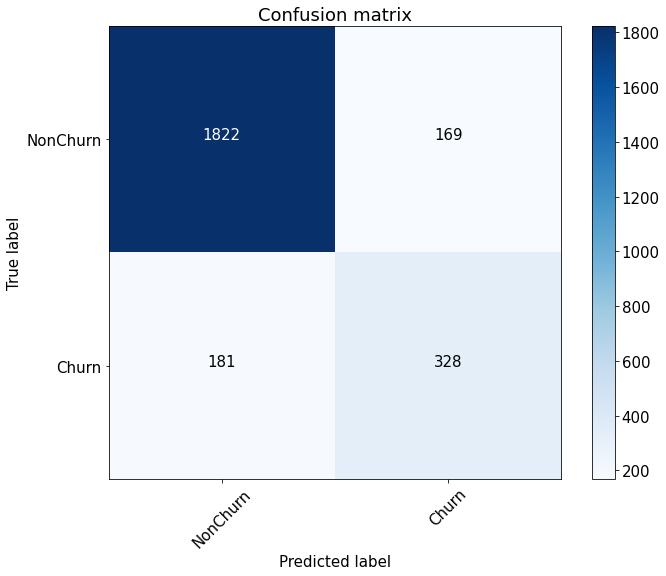

In [55]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds_lgbm)
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

# LogisticRegression

In [57]:
pipeline = Pipeline([
    ('features',feats),
    ('classifier', LogisticRegression(random_state = 42)),
])

In [58]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

In [59]:
preds = pipeline.predict_proba(X_test)[:, 1]
preds[:10]

array([0.22805865, 0.3350657 , 0.15347886, 0.12466446, 0.15507743,
       0.6431308 , 0.06214346, 0.077948  , 0.36717132, 0.76751542])

In [60]:
metrics_logreg, thresholds_logreg = cal_metrics(y_test, preds)

metrics_logreg

(0.7720774921330664, 0.5097001763668431, 0.4624, 0.5677799607072691)

Confusion matrix, without normalization
[[1655  336]
 [ 221  288]]


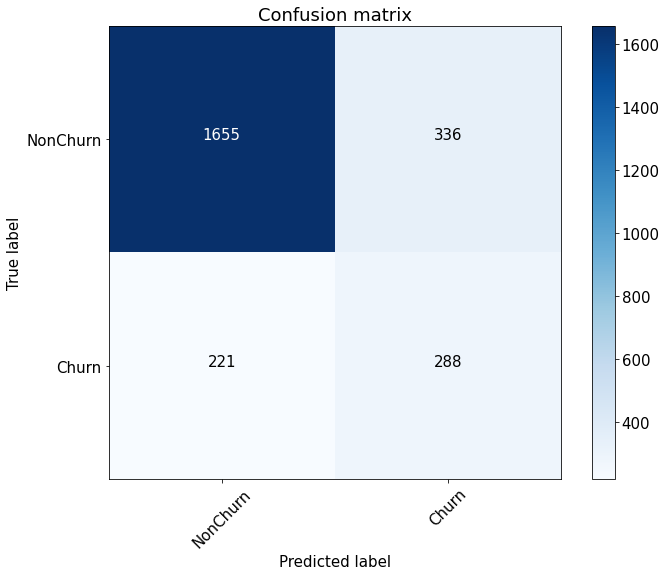

In [61]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds_logreg)
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [62]:
all_metrics = (metrics_forest, metrics_lgbm, metrics_logreg)

table = pd.DataFrame(list(all_metrics), columns=['roc-auc', 'f-score', 'precision', 'recall'], index=['RandomForestClassifier', 'LGBMClassifier', 'LogisticRegression'])

In [64]:
table

,roc-auc,f-score,precision,recall
RandomForestClassifier,0.863699,0.641283,0.654397,0.628684
LGBMClassifier,0.870576,0.653426,0.660643,0.646365
LogisticRegression,0.772077,0.509700,0.462400,0.567780


In [65]:
TP = 1729     
FP = 262
FN = 144       
TN = 365

In [66]:
efficiency = TP * 2 - TP - FP
print(f'Доход от использовния модели: {efficiency}$')

Доход от использовния модели: 1467$
